# MLP FASHION MNIST with reduce_on_plateau learning rate scheduler

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/google-deepmind/optax/blob/main/examples/contrib/reduce_on_plateau.ipynb)

In this notebook, we explore the power of `reduce_on_plateau` scheduler, that reduces the learning rate when a metric has stopped improving. We will be solving a classification task by training a simple Multilayer Perceptron (MLP) on the fashion MNIST dataset.

To run this example, you need Optax >= 0.1.9, grain for loading data, and the latest version of Orbax.

In [1]:
%pip install optax==0.1.9 grain-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.2/197.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.4/367.4 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: optax
    Found existing installation: optax 0.1.8
    Uninstalling optax-0.1.8:
      Successfully uninstalled optax-0.1.8


In [2]:
%pip install 'git+https://github.com/google/orbax/#subdirectory=checkpoint'

  Cloning https://github.com/google/orbax/ to /tmp/pip-req-build-8po1no69
  Running command git clone --filter=blob:none --quiet https://github.com/google/orbax/ /tmp/pip-req-build-8po1no69
  Resolved https://github.com/google/orbax/ to commit 9b37bfc105023eb62694fc4c6549cf9ea091e4e9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.0 MB/s eta 0:00:00
  Created wheel for orbax-checkpoint: filename=orbax_checkpoint-0.5.2-py3-none-any.whl size=143092 sha256=b00c41f92218b1ccc0509accbcc72cb79393f13428da96171251ff62dba50191
  Stored in directory: /tmp/pip-ephem-wheel-cache-gus33a3u/wheels/9c/e5/6a/7b8445b9cd87b57a6797ade2ac0b43fb40b2d640b3207f41c8
Successfully built orbax-checkpoint
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    

In [1]:
from typing import Sequence

import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
from optax import contrib
import grain.python as grain
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
# Show on which platform JAX is running.
print("JAX running on", jax.devices()[0].platform.upper())

JAX running on GPU


In [2]:
# @markdown The initial learning rate for the optimizer:
LEARNING_RATE = 0.01  # @param{type:"number"}
# @markdown Number of samples in each batch:
BATCH_SIZE = 128  # @param{type:"integer"}
# @markdown Total number of epochs to train for:
N_EPOCHS = 50  # @param{type:"integer"}
# @markdown Number of epochs with no improvement after which learning rate will be reduced:
PATIENCE = 5  # @param{type:"integer"}
# @markdown Number of epochs to wait before resuming normal operation after the learning rate reduction:
COOLDOWN = 0  # @param{type:"integer"}
# @markdown Factor by which to reduce the learning rate:
FACTOR = 0.5  # @param{type:"number"}
# @markdown Relative tolerance for measuring the new optimum:
RTOL = 1e-4  # @param{type:"number"}

Fashion MNIST is a dataset of 28x28 grayscale images, associated with a label from 10 classes. We now download the dataset using `tensorflow_datasets`, create a transformation to apply min-max normalization to the images, and another transformation to group each (image, label) as a tuple. Then we use `grain` to shuffle the data in the train set, apply our transformations, create batches of size `BATCH_SIZE`, and create a data loader.


In [3]:
fmnist_info = tfds.builder("fashion_mnist").info
fmnist_ds = tfds.data_source("fashion_mnist")

In [4]:
class MinMaxNormTransform(grain.MapTransform):
  """Apply min-max normalization to the images"""
  def map(self, element):
    element["image"] = element["image"].astype(jnp.float32) / 255.
    return element

class AsSupervisedTransform(grain.MapTransform):
  """Transform the input from a dictionary of features into 2-tuple structure (image, label)"""
  def map(self, element):
    return (element["image"], element["label"])


In [5]:
train_loader_batched = grain.load(
    source=fmnist_ds["train"],
    num_epochs=1,
    shuffle=True,
    transformations=[MinMaxNormTransform(), AsSupervisedTransform()],
    batch_size=BATCH_SIZE,
    drop_remainder=True,
    seed=0
)

test_loader_batched = grain.load(
    source=fmnist_ds["test"],
    num_epochs=1,
    transformations=[MinMaxNormTransform(), AsSupervisedTransform()],
    batch_size=BATCH_SIZE,
    drop_remainder=True,
    seed=0
)

NUM_CLASSES = fmnist_info.features["label"].num_classes
IMG_SIZE = fmnist_info.features["image"].shape

The data is ready! Next let's define a model. Optax is agnostic to which (if any) neural network library is used. Here we use Flax to implement a simple MLP.

In [6]:
class MLP(nn.Module):
  """A simple multilayer perceptron model for image classification."""
  hidden_sizes: Sequence[int] = (1000, 1000)

  @nn.compact
  def __call__(self, x):
    # Flattens images in the batch.
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(features=self.hidden_sizes[0])(x)
    x = nn.relu(x)
    x = nn.Dense(features=self.hidden_sizes[1])(x)
    x = nn.relu(x)
    x = nn.Dense(features=NUM_CLASSES)(x)
    return x

In [7]:
net = MLP()


@jax.jit
def loss_accuracy(params, data):
  """Computes loss and accuracy over a mini-batch.

  Args:
    params: parameters of the model.
    data: tuple of (inputs, labels).

  Returns:
    loss: float
  """
  inputs, labels = data
  logits = net.apply({"params": params}, inputs)
  loss = optax.softmax_cross_entropy_with_integer_labels(
      logits=logits, labels=labels
  ).mean()
  accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
  return loss, {"accuracy": accuracy}

Next we initialize network parameters.

In [8]:
rng = jax.random.PRNGKey(0)
fake_data = jnp.ones((1,) + IMG_SIZE, dtype=jnp.float32)
parameters = net.init({"params": rng}, fake_data)["params"]


def dataset_stats(params, data_loader):
  """Computes loss and accuracy over the dataset `data_loader`."""
  all_accuracy = []
  all_loss = []
  for batch in data_loader:
    batch_loss, batch_aux = loss_accuracy(params, batch)
    all_loss.append(batch_loss)
    all_accuracy.append(batch_aux["accuracy"])
  return {"loss": np.mean(all_loss), "accuracy": np.mean(all_accuracy)}

Here we initialize the solver. Note that during the training process, the learning rate of the solver remains unchanged.

In [9]:
solver = optax.adam(LEARNING_RATE)
solver_state = solver.init(parameters)

In the next cell, we initialize the `contrib.reduce_on_plateau` scheduler, which reduces learning rate when a monitored metric has stopped improving. We will be using this scheduler to scale the updates, produced by the regular Adam optimizer.

Additionally, the code initializes the state for the scheduler by calling `transform.init(parameters)`. Note that the initial learning rate for the scheduler is not explicitly set, so it will default to 1.0, which means there will be no scaling of the learning rate initially.

In [10]:
transform = contrib.reduce_on_plateau(
    patience=PATIENCE, cooldown=COOLDOWN, factor=FACTOR, rtol=RTOL)

# Creates initial state for `contrib.reduce_on_plateau` transformation.
transform_state = transform.init(parameters)
transform_state

ReduceLROnPlateauState(lr=Array(1., dtype=float32), best_loss=Array(inf, dtype=float32), plateau_count=Array(0, dtype=int32), cooldown_counter=Array(0, dtype=int32))

The next cell trains the model for `N_EPOCHS` epochs. At the end of each epoch, the learning rate scaling value is updated based on the loss computed on the test set.

In [11]:
@jax.jit
def train_step(params, solver_state, transform_state, batch):
  """Performs a one step update."""
  (loss, aux), grad = jax.value_and_grad(loss_accuracy, has_aux=True)(
      params, batch
  )
  # Computes updates scaled by the learning rate that was used to initialize
  # the `solver`.
  updates, solver_state = solver.update(grad, solver_state, params)
  # Scales updates, produced by `solver`, by the scaling value.
  updates, _ = transform.update(
      updates=updates, state=transform_state, loss=test_stats["loss"])
  params = optax.apply_updates(params, updates)
  return params, solver_state, loss, aux


train_accuracy = []
train_losses = []

# Computes test set accuracy at initialization.
test_stats = dataset_stats(parameters, test_loader_batched)
test_accuracy = [test_stats["accuracy"]]
test_losses = [test_stats["loss"]]

lr_scale, _, _, _ = transform_state
lr_scale_history = [lr_scale]
for epoch in range(N_EPOCHS):
  train_accuracy_epoch = []
  train_losses_epoch = []

  for train_batch in train_loader_batched:
    parameters, solver_state, train_loss, train_aux = train_step(
        parameters, solver_state, transform_state, train_batch
    )
    train_accuracy_epoch.append(train_aux["accuracy"])
    train_losses_epoch.append(train_loss)

  test_stats = dataset_stats(parameters, test_loader_batched)
  test_accuracy.append(test_stats["accuracy"])
  test_losses.append(test_stats["loss"])
  # Adjusts the learning rate scaling value using the loss computed on the
  # test set.
  _, transform_state = transform.update(
      updates=parameters, state=transform_state, loss=test_stats["loss"])
  lr_scale, _, _, _ = transform_state
  lr_scale_history.append(lr_scale)
  mean_train_accuracy = np.mean(train_accuracy_epoch)
  print(f"Epoch {epoch + 1}/{N_EPOCHS}, mean train accuracy: {mean_train_accuracy}")
  train_accuracy.append(mean_train_accuracy)
  train_losses.append(np.mean(train_losses_epoch))

Epoch 1/50, mean train accuracy: 0.801148533821106
Epoch 2/50, mean train accuracy: 0.8498764634132385
Epoch 3/50, mean train accuracy: 0.8592748641967773
Epoch 4/50, mean train accuracy: 0.8620960116386414
Epoch 5/50, mean train accuracy: 0.8668035268783569
Epoch 6/50, mean train accuracy: 0.8688401579856873
Epoch 7/50, mean train accuracy: 0.87109375
Epoch 8/50, mean train accuracy: 0.8743823170661926
Epoch 9/50, mean train accuracy: 0.8762853741645813
Epoch 10/50, mean train accuracy: 0.876769483089447
Epoch 11/50, mean train accuracy: 0.8752670884132385
Epoch 12/50, mean train accuracy: 0.8785557150840759
Epoch 13/50, mean train accuracy: 0.8797910213470459
Epoch 14/50, mean train accuracy: 0.8814436197280884
Epoch 15/50, mean train accuracy: 0.8785557150840759
Epoch 16/50, mean train accuracy: 0.8819444179534912
Epoch 17/50, mean train accuracy: 0.883713960647583
Epoch 18/50, mean train accuracy: 0.8919270634651184
Epoch 19/50, mean train accuracy: 0.8850327134132385
Epoch 20/50, 

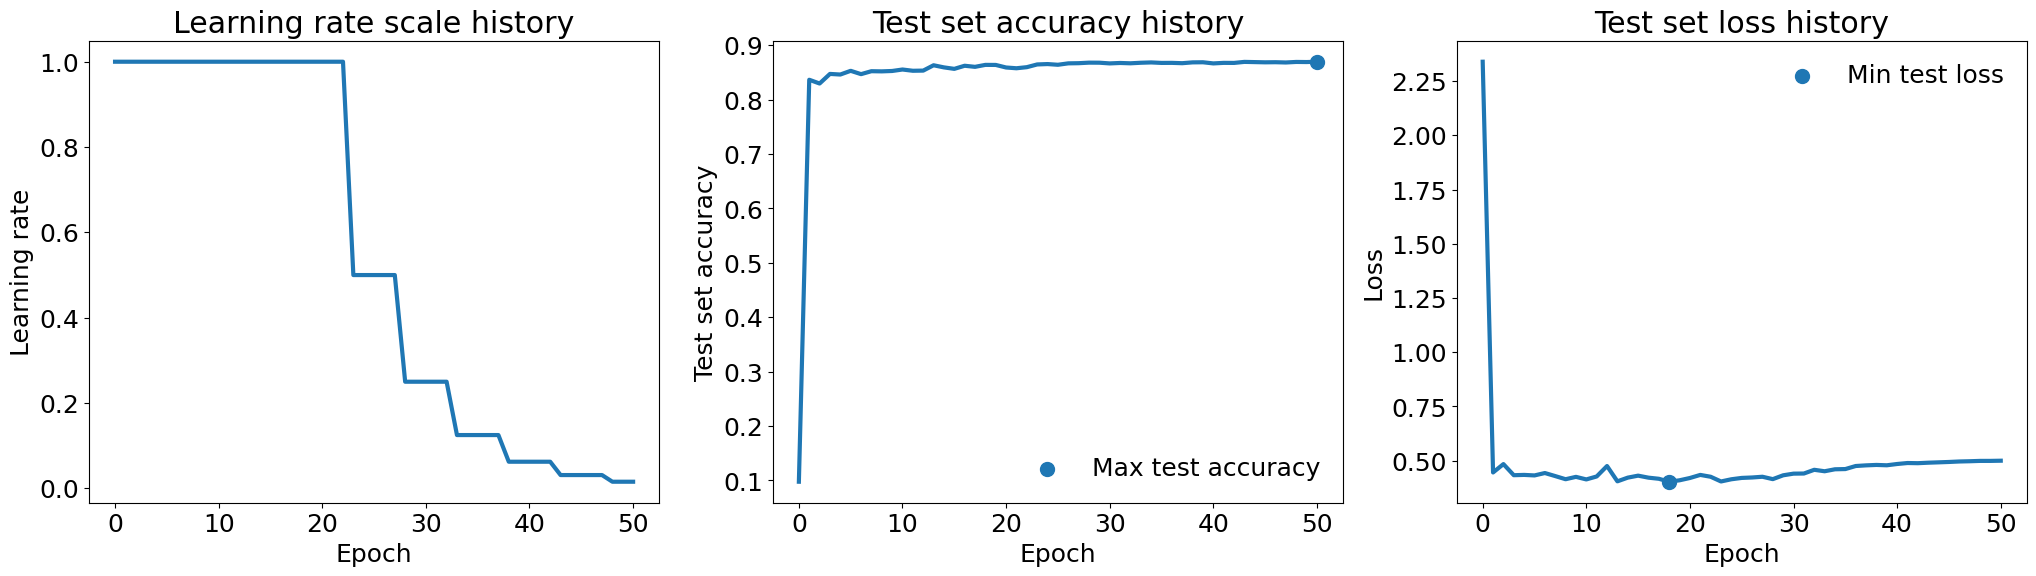

In [12]:
plt.rcParams["figure.figsize"] = (25, 6)
plt.rcParams.update({"font.size": 18})

fig, axs = plt.subplots(ncols=3)

axs[0].plot(lr_scale_history, lw=3)
axs[0].set_title("Learning rate scale history")
axs[0].set_ylabel("Learning rate")
axs[0].set_xlabel("Epoch")


axs[1].plot(test_accuracy, lw=3)
axs[1].scatter(
    jnp.argmax(jnp.array(test_accuracy)),
    max(test_accuracy),
    label="Max test accuracy",
    s=100,
)
axs[1].set_title("Test set accuracy history")
axs[1].set_ylabel("Test set accuracy")
axs[1].legend(frameon=False)
axs[1].set_xlabel("Epoch")

axs[2].plot(test_losses, lw=3)
axs[2].scatter(
    jnp.argmin(jnp.array(test_losses)),
    min(test_losses),
    label="Min test loss",
    s=100,
)
axs[2].set_title("Test set loss history")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Loss")
axs[2].legend(frameon=False)

fig.show()